# Support Vector Machines: A Survey of its Applications with Special Emphasis on Facial Recognition Technology
> Introducing support vector machines while observing its use in the real world, with special consideration to facial recognition.

- toc: false
- branch: master
- badges: true
- comments: false
- author: Kevin Le
- categories: [fastpages, jupyter]

While some supervised machine learning models aim to draw numerical predictions given a set of features and target variable, other models aim to accurately classify data points to their corresponding labels given their features. These problems make up a vast subset of supervised machine learning problems, called classification problems. Several techniques, including logistic regression, decision tree classification, and others, are used to solve these problems. While the premise of classification problems is to determine a decision boundary that separates the data, each technique leverages different numerical properties of the data to discern these boundaries. In this article, we will be focusing on support vector machines, which use the data’s geometric properties to create a separating decision “slab”. More on that in a bit. 

At first glance, support vector machines sound like something you’d find in Tesla’s gigafactory, but they’re anything but that. We’ll be running through the (mathematical) mechanics of support vector machines, surveying its many applications, and examining the usage of support vector machines in facial recognition technology, along with its ethical considerations. 

## Introduction
This section will provide you everything you need to know about SVMs in a quick, but comprehensive manner before we explore how they’re applied in different contexts, especially in facial recognition.

## What are support vector machines? 
The support vector machine (SVM) is a supervised machine learning algorithm that can perform classification, regression, and outlier detection; however, we'll introduce the SVM with respect to binary classification, where we classify data points between two possible labels. Think of it almost like a yes or no problem! 

As previously stated, the goal of classification algorithms is to determine a decision boundary that best separates points with different labels. In terms of yes/no, we want to separate all the points that correspond to 'yes' from those that correspond to 'no'. SVMs can create decision boundaries of different shapes, called kernels, but we'll first focus on the linear SVM classifier. More specifically, let's start with hard-margin support vector machines. 

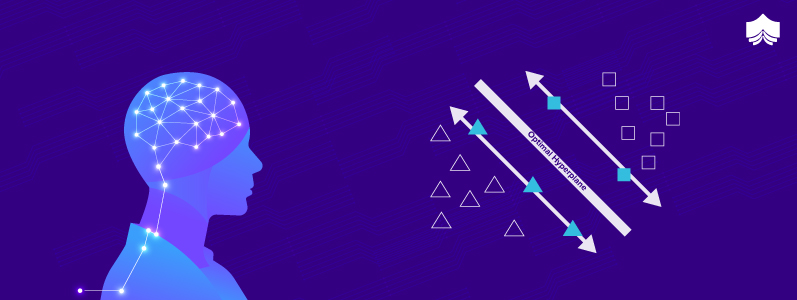

### Hard-margin SVM
Hard-margin SVM and linear SVM classifiers essentially go hand-in-hand. When using hard-margin SVMs, we want to find the widest linear decision boundary that separates the two classes of points. While this can sometimes be easily discerned by our visual cortex, if we wanted to draw a line between the points, there are actually an infinite number of possible lines to draw. That's where SVMs come into play. They determine the hyperplane that optimally separates the data. Think of our decision boundary as a separating slab, centered around a line that cuts through the space separating the classes of points. The visualization below, originally provided by [Samuel S. Watson, PhD](http://www.math.brown.edu/swatson2/index.html), provides visual intuition behind hard-margin SVMs. 

In [2]:
# hide
import Pkg;
Pkg.add("Plots")
Pkg.add("Distributions")
Pkg.add("JuMP")
Pkg.add("Ipopt")
Pkg.add("Random")

   Updating registry at `~/.julia/registries/General`
######################################################################### 100.0%
  Resolving package versions...
  Installed ZeroMQ_jll ─ v4.3.2+5
######################################################################### 100.0%
No Changes to `~/.julia/environments/v1.5/Project.toml`
Updating `~/.julia/environments/v1.5/Manifest.toml`
  [56f22d72] + Artifacts v1.3.0
  [6e34b625] ↑ Bzip2_jll v1.0.6+4 ⇒ v1.0.6+5
  [b22a6f82] ↑ FFMPEG_jll v4.3.1+2 ⇒ v4.3.1+4
  [d7e528f0] ↑ FreeType2_jll v2.10.1+4 ⇒ v2.10.1+5
  [559328eb] ↑ FriBidi_jll v1.0.5+5 ⇒ v1.0.5+6
  [692b3bcd] + JLLWrappers v1.1.3
  [c1c5ebd0] ↑ LAME_jll v3.100.0+2 ⇒ v3.100.0+3
  [dd192d2f] ↑ LibVPX_jll v1.9.0+0 ⇒ v1.9.0+1
  [c8ffd9c3] ↑ MbedTLS_jll v2.16.8+0 ⇒ v2.16.8+1
  [e7412a2a] ↑ Ogg_jll v1.3.4+1 ⇒ v1.3.4+2
  [458c3c95] ↑ OpenSSL_jll v1.1.1+5 ⇒ v1.1.1+6
  [91d4177d] ↑ Opus_jll v1.3.1+2 ⇒ v1.3.1+3
  [8f1865be] ↑ ZeroMQ_jll v4.3.2+4 ⇒ v4.3.2+5
  [83775a58] ↑ Zlib_jll v1.2.11+

LoadError: ArgumentError: Unsupported architecture 'aarch64' for macOS

In [6]:
# hide
using Plots, Distributions, JuMP, Random
gr(fontfamily = "Palatino", size = (400,400), aspect_ratio = 1, legend = false);

In [8]:
# hide
n = 20 
Random.seed!(123)
X = [randn(n) .- 4 randn(n) .+ 4
    randn(n) .+ 3 randn(n)]
y = repeat([1, -1], inner = n)
function original_scatter()
    scatter(X[:, 1], X[:, 2], group=y)
end

original_scatter (generic function with 1 method)

In [9]:
# hide 
(a, b), (c,d) = (-4.0, -2.4), (2.8, 7.7)
function add_line!()
    plot!([(a,b),(c,d)], linewidth = 1.5)
end

add_line! (generic function with 1 method)

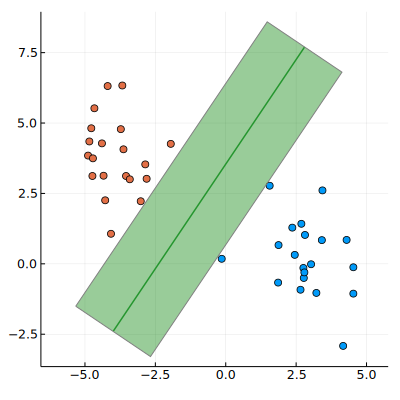

In [11]:
# hide_input
#Pkg.add("LinearAlgebra")
#using LinearAlgebra
function slab(a,b,c,d,w)
    v = [b-d, c-a]
    v *= w/norm(v)
    Tuple.([[a,b] + v, [c,d] + v, [c,d] - v, [a,b] - v, [a,b] + v])
end
function add_slab!()
    plot!(slab(a,b,c,d,1.6), fillopacity = 0.4, seriestype = :shape, fillcolor = :green, linecolor = :gray)
end
original_scatter()
add_line!()
add_slab!()

Mathematically, the slab represents the region between two parallel hyperplanes. The goal is to look for the thickest separating slab and choose the hyperplane in the middle as the decision boundary. Some points reside on the boundaries of the slab. These are **support vectors**, hence the name support vector machine. In essence, points that lie on one side of the slab will be classified as one label, and points that lie on the opposite side will be classified as another. 

Hard-margin SVMs determine the thickest separating slab between classes of points through **constrained optimization**. Suppose our observations are (x,y), where $y$ can assume the value of $+1$ or $-1$. Our separating slab can be described as ${x \in \mathbf{R^2}: -1 \leq \beta'\mathbf{x} + \alpha \leq 1}$, and the total width of the slab is $\frac{2}{|\beta|}$. We can check whether a point is on the correct side by evaluating whether $y_i (\beta \cdot x_i + \alpha) \geq 1$. This is the correct way of checking side membership. Let's say we have a point with label $-1$. If we were to multiply $-1$ by the value of the boundary closes to the cluster of $-1$ points, represented by $\beta \cdot x_i + \alpha = -1$, we'd obtain a positive number. The same principle applies to all $+1$ points.

To obtain the thickest slab, we need to minimize $\beta$, because $\beta$ is in the denominator for our equation for slab width. By minimizing $\beta$, we maximize slab width. However, we subject our optimization to the constraint $y_i (\beta \cdot x_i + \alpha) \geq 1$. That is, we're looking for the widest separating slab such that all the points are still on the correct side. These are the general principles of hard-margin SVMs. 

In practice, not all data are so easily separable like the one given in our visualization. Therefore, we need to find a way to determine separating slabs in cases where the data aren't easily separable. Allow me to introduce the soft-margin SVM.

### Soft-margin SVM
Soft-margin SVMs overcome the problem of data inseparability by incurring a penalty term to all misclassified points. This penalty term is included in our loss function, which we will be trying to minimize in our pursuit of a separating slab. 

$$L(\beta,\alpha) = \lambda|\beta|^2 + \frac{1}{n}\sum_{i=1}^n [1 - y_i(\beta \cdot \mathbf{x_i} + \alpha]$$

We penalize by units of slab half-widths. All points on the midline get a penalty of 1, and so on. The parameter $\lambda$ mediates the tradeoff between maximizing slab width and the correcness incentive of the second. Soft-margin SVMs work better than hard-margin SVMs because misclassified points are actually infinitely penalized in hard-margin SVMs. If you think about it, if points were jumbled all together, the resulting separating slab from the hard-margin SVM would be incredibly small. 